<a href="https://colab.research.google.com/github/pastenar/pytorch101/blob/main/1_0_pytorch_workflow_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Workflow

Resources:
- repo: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
- online book: https://www.learnpytorch.io/01_pytorch_workflow/

Items:
1. Data (prepare and load)
2. Build a model
3. Fitting model to data (training)
4. making predictions and evaluating the model (inference).
5. saving and load the model
6. putting all together.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu124'

## Data (preparing and loading)

### Splitting Data



In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [3]:
# Create train - test split.

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [4]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):

  plt.figure(figsize=(8,5))
  # Plot Train data
  plt.scatter(train_data, train_labels, c='b', s=4, label="Training data ")
  # Plot Test data
  plt.scatter(test_data, test_labels, c='g', s=4, label="Testng data ")

  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

  plt.legend(prop={'size':14})


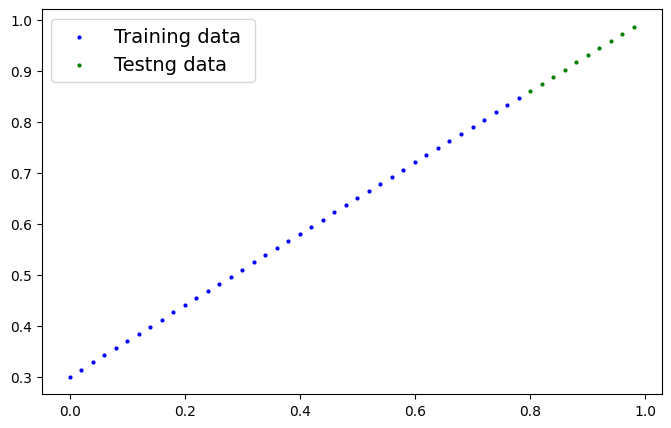

In [5]:
plot_predictions()

## 2. Build a Model

Build a linear regression model

In [6]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Initialise model parameters
    self.weights = nn.Parameter(torch.rand(1,
                                           requires_grad = True, # if the parameter requires gradeient, torch.autograd
                                           dtype = torch.float))

    self.bias = nn.Parameter(torch.rand(1,
                                        requires_grad = True,
                                        dtype = torch.float))

  # Forward method to define the computation in the model (at call)
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias


Pytorch model building essentials

* ``torch.nn`` - contains all of the buildings for computational graphs
* ``torch.nn.Parameters`` - what parameters should our model try and learn, often a PyTorch layer  from torch.nn will set these for us
* ``torch.nn.Module`` - The base class for all neural modules, if you subclass it, you should overwrite forward()
* ``torch.optim`` - this where the optimizer in Pytorch live, They will help with gradient descent
* ``def forward()`` - All nn.Module require you to overwrite forward(), this method overwrite defines what happens in the forward computation.


In [7]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [8]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

### Make predictions using ``torch.inference_mode()``


In [9]:
with torch.inference_mode():
  y_preds = model_0(X_test)

# Other option but not preferred:
#   with torch.no_grad():
#     y_preds = model_0(X_test)

y_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

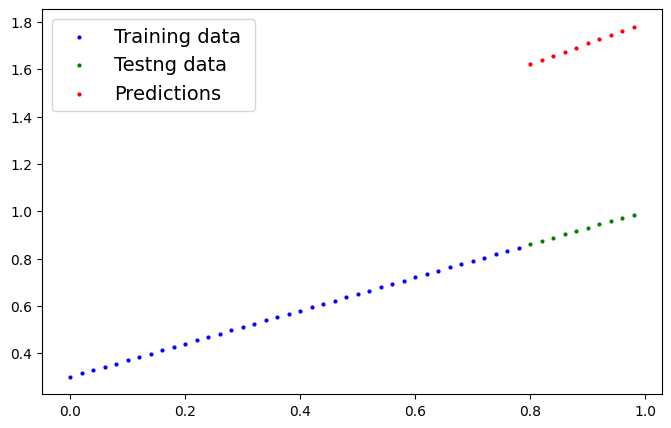

In [10]:
plot_predictions(predictions=y_preds)

## Train  Model

What's needed:
  - **Loss function**: how wrong your model predictions, lower is better
  - **Optimizer**: adjust base in the loss function

for pytorch you need:
  - A training loop
  - A testin loop

In [11]:
# Loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr = 0.01 # learning rate,
                            )


### Building a training loop (and testing)

Whats need:
0. Loop through the data
1. Forward pass (data moving through ``forward()`` of the model) to make predictions - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truht labels)
3. Optimzer zero grad
4. Loss backward - move backward throught the network to calculate the gradients of each of the parameters of our model with respecto to the loss (**backpropagation**)
5. Optimizer step - use optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [12]:
# the number of loops over the data
epochs = 100

epoch_count = []
loss_values = []
test_loss_values = []



## TRAINING

# 0. Loop through data
for epoch in range(epochs):
  # Set modelo to training mode
  model_0.train()

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # print(f'Loss: {loss}')

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()
  with torch.inference_mode(): # turn off the gradient
     # 1. Do the forward pass
     test_pred = model_0(X_test)
     # 2. Calculate the loss
     test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')
    print(model_0.state_dict())

  # Testing
  model_0.eval()


Epoch: 0 | Loss: 0.6860889196395874 | Test loss: 0.7637526988983154
OrderedDict([('weights', tensor([0.8784])), ('bias', tensor([0.9050]))])
Epoch: 10 | Loss: 0.5708791017532349 | Test loss: 0.6290428042411804
OrderedDict([('weights', tensor([0.8394])), ('bias', tensor([0.8050]))])
Epoch: 20 | Loss: 0.45566922426223755 | Test loss: 0.4943329691886902
OrderedDict([('weights', tensor([0.8004])), ('bias', tensor([0.7050]))])
Epoch: 30 | Loss: 0.34045934677124023 | Test loss: 0.35962313413619995
OrderedDict([('weights', tensor([0.7614])), ('bias', tensor([0.6050]))])
Epoch: 40 | Loss: 0.2252494841814041 | Test loss: 0.2249133139848709
OrderedDict([('weights', tensor([0.7224])), ('bias', tensor([0.5050]))])
Epoch: 50 | Loss: 0.1100396141409874 | Test loss: 0.09020347893238068
OrderedDict([('weights', tensor([0.6834])), ('bias', tensor([0.4050]))])
Epoch: 60 | Loss: 0.009724985808134079 | Test loss: 0.020998019725084305
OrderedDict([('weights', tensor([0.6539])), ('bias', tensor([0.3200]))])

In [13]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

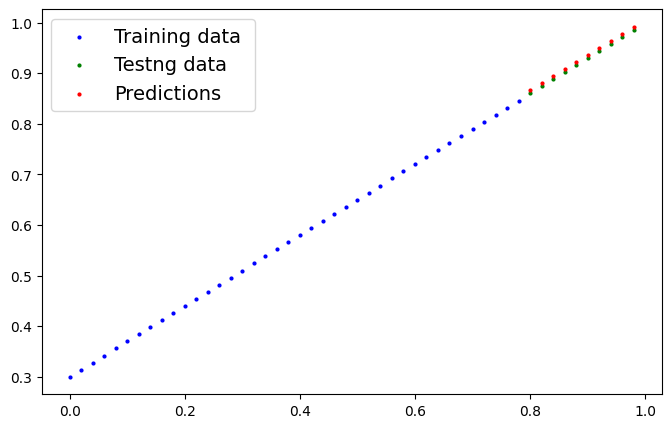

In [14]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
plot_predictions(predictions=y_preds_new)

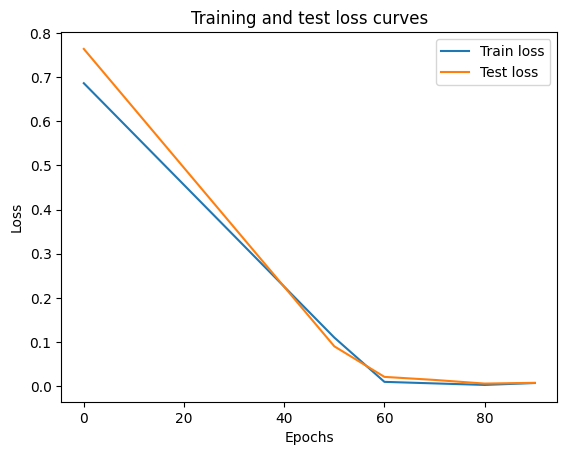

In [15]:
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## Save the model

There are three main methods you should about for saving and loading models in PyTorch.

1.  `torch.save()` - allows you save a pytorch object in pytorch's pickle format
2.  `torch.load()` - allow you load a saved pytorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

documentation: https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [16]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

In [17]:
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = '1_0_pytorch_workflow_code.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/1_0_pytorch_workflow_code.pth


In [18]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1668 Feb 19 21:49 1_0_pytorch_workflow_code.pth


## Loading a PyTorch model

In [19]:
# To load in a saved state_dict we hace to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-19-1573e0dcdff2>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [20]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

In [21]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8661],
        [0.8801],
        [0.8940],
        [0.9080],
        [0.9220],
        [0.9359],
        [0.9499],
        [0.9638],
        [0.9778],
        [0.9917]])

In [22]:
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Putting all together

In [23]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu124'

Create device-agnostic code
This means if we've got access to a GPU, our coud will use it

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

Using device: cuda


In [25]:
!nvidia-smi

Wed Feb 19 21:51:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Data

In [26]:
# Create some data using the linear regression formula

weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [28]:
# Split data
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

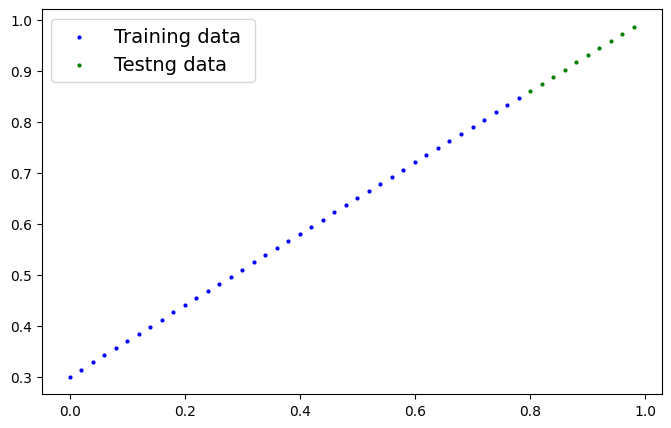

In [29]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

### Building a pytorch linear model

In [32]:
# Create a linear model by subclassing nn.Module
class LinearRegModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters (#input size / output size)
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)


# Set seed
torch.manual_seed(42)
model_1 = LinearRegModel()
model_1, model_1.state_dict()

(LinearRegModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [36]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Training

* Loss function
* Optimizer
* Training loop
* Test loop


In [41]:
# loss function
loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.01)

In [43]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data in GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # print out whats happening

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [44]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### Making and evaluating predictions

In [46]:
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

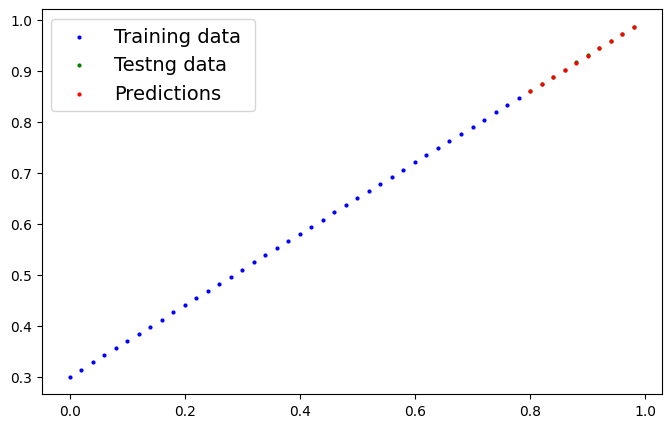

In [47]:
plot_predictions(predictions=y_preds.cpu())

### Saving & loading a trained model

In [50]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "1_0_pytorch_workflow_code.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_1.state_dict(),
          f=MODEL_SAVE_PATH)

Saving model to: models/1_0_pytorch_workflow_code.pt


### Load a pytorch model

In [69]:
loaded_model_1 = LinearRegModel()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

<ipython-input-69-f779942bc39d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


LinearRegModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [70]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [71]:
X_test.device

device(type='cuda', index=0)

In [72]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [73]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Exercises & Extra